In [1]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

In [2]:
# results_dir = "results/multiview_experiments_0.6M_BMIMI_RandomForestClassifier"
#results_dir = "results/multiview_experiments_0.7M_BMIMTfO_RandomForestClassifier"
# results_dir = "results/multiview_experiments_0.9M_BMIMBr_RandomForestClassifier"
# results_dir = "results/multiview_experiments_1.2M_BMIMCl_RandomForestClassifier"
# results_dir = "results/multiview_experiments_avgfp_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BG_STRSQ_Abate2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Ostermeier2014_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Palzkikll2012_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Ranganathan2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Tenaillon2013-singles_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BRCA1_HUMAN_Fields2015_e3_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BRCA1_HUMAN_Fields2015_y2h_RandomForestClassifier"
# results_dir = "results/multiview_experiments_DLG4_RAT_Ranganathan2012_RandomForestClassifier"
# results_dir = "results/multiview_experiments_GAL4_YEAST_Shendure2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_HG_FLU_Bloom2016_RandomForestClassifier"
# results_dir = "results/multiview_experiments_HSP82_YEAST_Bolon2016_RandomForestClassifier"

results_dir = "results/multiview_experiments_avgfp_RandomForestClassifier"
#results_dir = "results/multiview_experiments_avgfp_LogisticRegression"

In [3]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", "ProtVec"]
# Get list of tuples from combinations
labeled_sizes = [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
#labeled_sizes = [0.15, 0.1, 0.05]
comb = list(combinations(encodings, 2))

In [4]:
global_pred_dict = dict()

for enc1, enc2 in comb:
    global_pred_dict[f"cotraining-{enc1}-{enc2}"] = dict()
    global_pred_dict[enc1] = dict()
    global_pred_dict[enc2] = dict()
    global_pred_dict["concat-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-lr-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-mean-"+enc1+"-"+enc2] = dict()

    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/pred_dict_ct_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[f"cotraining-{enc1}-{enc2}"][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_{enc1}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc1][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc2][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_concat_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict["concat-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_st_lr_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict["st-lr-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_st_mean_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict["st-mean-"+enc1+"-"+enc2][labeled_size] = pkl.load(f)

# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'Train_size', 'View', 'AUC'])
for view, labeled_sizes in global_pred_dict.items():
    for labeled_size, preds_list in labeled_sizes.items():
        for preds in preds_list:
            # if view.startswith("st-lr-"):
            #     y_proba = 1 -preds["y_proba"]
            # else:
            #     y_proba = preds["y_proba"]
            y_proba = preds["y_proba"]
            original_y_test = preds["original_y_test"]
            y_test = preds["y_test"]
            train_size = preds["train_len"]
            auc = roc_auc_score(y_test, y_proba)
            spearman_r = spearmanr(original_y_test, y_proba)[0]
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'View': view, 
                                              'AUC': auc, 
                                              'Spearman_r': spearman_r
                                              }, index=[0])], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'results/multiview_experiments_avgfp_RandomForestClassifier/pred_dict_ct_Micheletti_potentials_ProtVec_0.5.pickle'

In [5]:
def get_one_vs_all_results(df, metric, encodings, view, views):
    # Read times best from pkl for each results folder (each pair of encodings)
    one_vs_all_dict = dict()

    # Shape of the dictionary pickled is:
    # cotraining_vs_best_dict -> labeled_percentage -> k -> difference from cotraining auc to best

    # Getting mean results from kfold
    comb = combinations(encodings, 2)
    for enc1, enc2 in comb:
        one_vs_all_dict[(enc1, enc2)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            means = dict()
            means["CoTraining"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"cotraining-{enc1}-{enc2}")][metric].mean()
            means["View1"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc1)][metric].mean()
            means["View2"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc2)][metric].mean()
            means["Concat"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"concat-{enc1}-{enc2}")][metric].mean()
            means["Stacking-lr"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-lr-{enc1}-{enc2}")][metric].mean()
            means["Stacking-mean"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-mean-{enc1}-{enc2}")][metric].mean()

            # Get the difference between cotraining and best
            # Get the difference between means[view] and the maximum of the rest of the values of the dictionary
            one_vs_all_dict[(enc1, enc2)][labeled_percentage] = means[view] - max([means[rival] for rival in views if rival != view])
    return one_vs_all_dict

In [6]:
import pandas as pd

def create_heatmap_dict(one_vs_all_dict, labeled, view):

    heatmap_dict = {}

    number_of_experiments = 0
    for encodings, results in one_vs_all_dict.items():
        enc1, enc2 = encodings
        
        heatmap_dict[(enc1, enc2)] = results[labeled]

    ser = pd.Series(list(heatmap_dict.values()),
                    index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
    df = ser.unstack().fillna(0)

    # Set values from (index1, index2) to (index2, index1)
    for index1, index2 in one_vs_all_dict.keys():
        # Create index if it doesn't exist
        if index2 not in df.index:
            df.loc[index2] = 0
        if index1 not in df.columns:
            df[index1] = 0
        df.loc[index2, index1] = df.loc[index1, index2]

    # Sort indexes by name
    df = df.sort_index(axis=0)
    df = df.sort_index(axis=1)

    # Set new column and index order
    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based

    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                    "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                    "Evolution": ['PAM250', 'BLOSUM62'],
                    "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                    "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}

    new_index_order = new_columns_order
    df = df.reindex(new_index_order, axis=0)
    df = df.reindex(new_columns_order, axis=1)

    # Set heatmap limits to 1 and 0
    # Hide heatmap legend
    sns.heatmap(df, cmap="RdYlGn", center=0)#, vmin=-0.1, vmax=0.1)
    # Group heatmap columns by group
    for group, encodings in groups_dict.items():
        plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
        
    # Set title
    plt.title(f'{view} being best | {labeled*100}% labeled)', fontsize=14)
    plt.show()
    return df

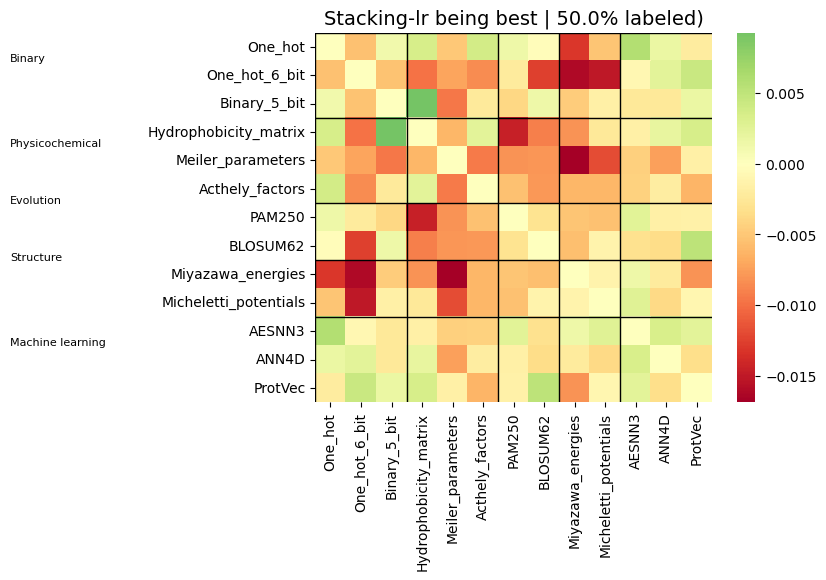

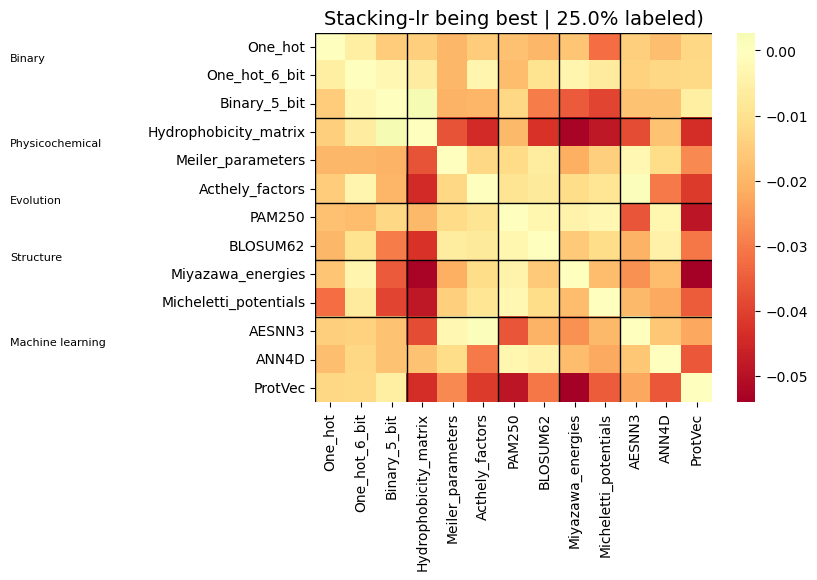

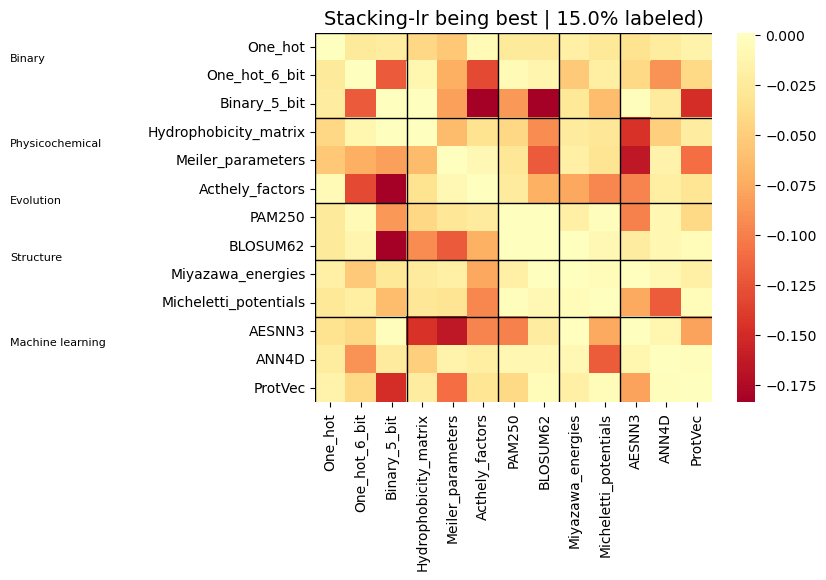

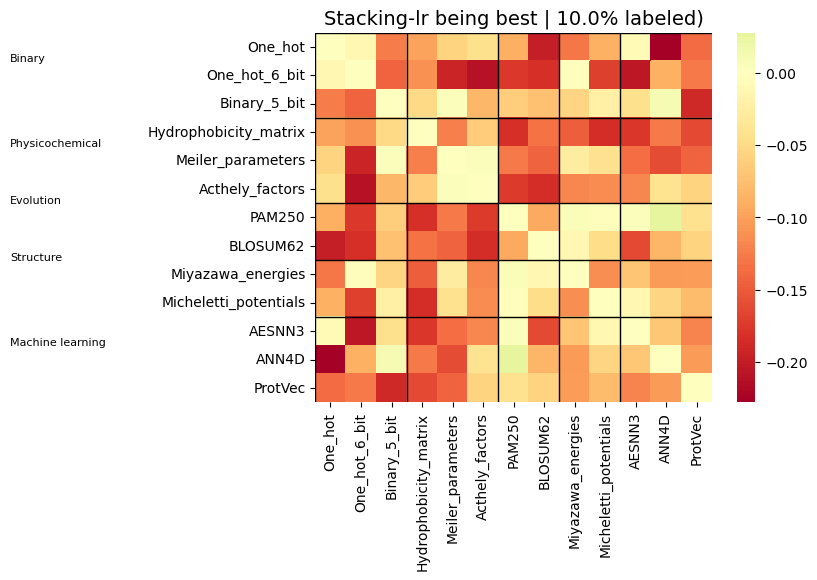

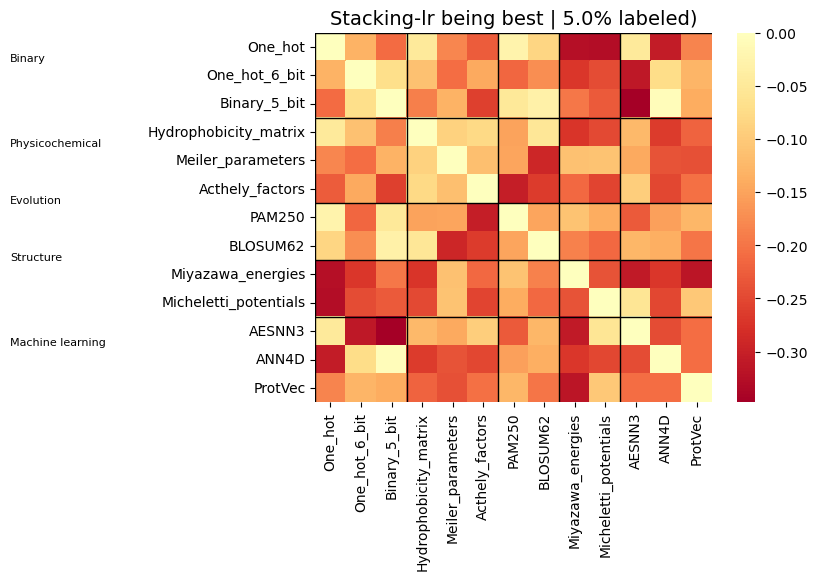

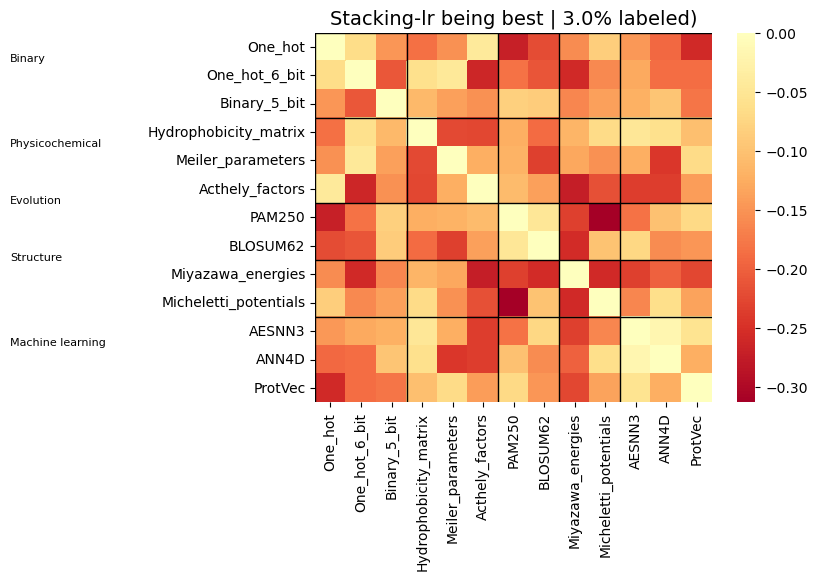

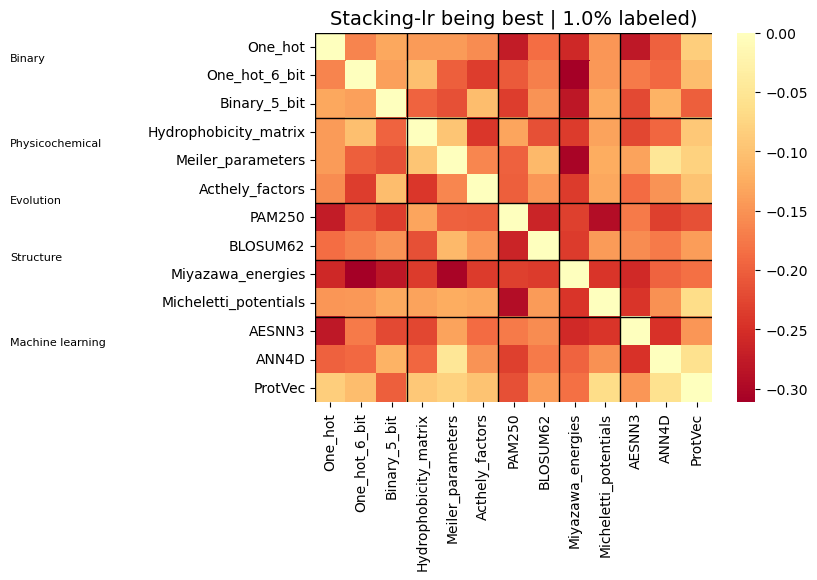

In [7]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
for labeled_size in labeled_sizes:
    # CoTraining, Concat, Stacking-lr, Stacking-mean, View1 or View2
    
    #view = "Concat" 
    view = "Stacking-lr"
    
    #views =  ["CoTraining", "Concat", "View1", "View2"]
    views =  ["CoTraining", "Concat", "Stacking-mean", "View1", "View2"]
    
    #one_vs_all_dict = get_one_vs_all_results(df, "AUC", encodings, view, views) 
    one_vs_all_dict = get_one_vs_all_results(df, "Spearman_r", encodings, view, views) 
    create_heatmap_dict(one_vs_all_dict, labeled_size, view);


# Boxplots for a encoding pair

In [10]:
#selected_metric = "AUC"
selected_metric = "Spearman_r"

/tmp/ipykernel_1181781/1534523472.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df.loc[:, 'Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_1181781/1534523472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


Text(0.5, 1.0, 'One_hot vs Micheletti_potentials | Spearman_r by view | 5-fold CV')

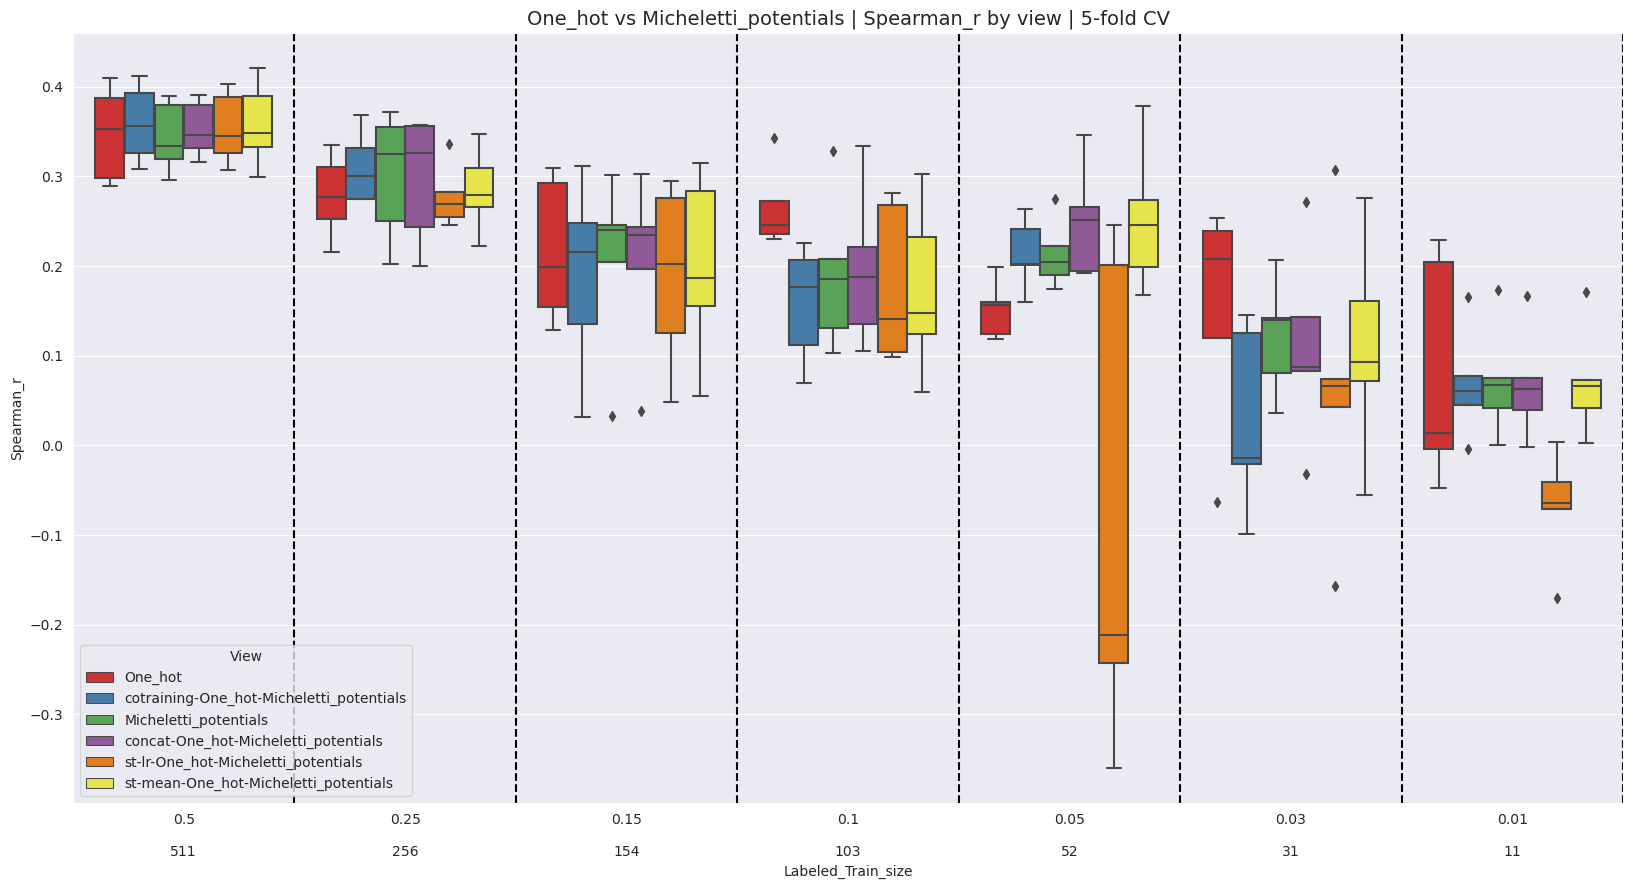

In [12]:
enc1 = 'One_hot'
enc2 = 'Micheletti_potentials'
#for enc1, enc2 in combinations(encodings, 2):
# Boxplot for folds aucs
plt.figure(figsize=(20, 10))

boxplot_df = df.loc[(df['View'] == f"cotraining-{enc1}-{enc2}") | (df['View'] == enc1) | (df['View'] == enc2) | (df['View'] == f"concat-{enc1}-{enc2}") | (df['View'] == f"st-lr-{enc1}-{enc2}") | (df['View'] == f"st-mean-{enc1}-{enc2}")]
boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)
# Boxplot grouped by labeled
# Vertical and horizontal grid background
sns.set_style("darkgrid")
# Add underscore at the beginning of every instance in view column in boxplot_df
# pointplot_df = boxplot_df.copy()
# pointplot_df["View"] = pointplot_df['View'].apply(lambda x: f"_{x}")
# ax = sns.pointplot(data=pointplot_df, x='Labeled', y='AUC', 
#                     hue='View', ci=None, linestyles=":",
#                     dodge=.8-0.8/4, scale=0.8, markers="",
#                     palette="Set1")
#plt.setp(ax.lines, zorder=0)
sns.boxplot(x="Labeled_Train_size", y=selected_metric, hue="View", data=boxplot_df, palette="Set1")
[plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
plt.title(f'{enc1} vs {enc2} | {selected_metric} by view | 5-fold CV', fontsize=14)
#plt.gca().invert_xaxis()

# Ranking of encoding couples for each labeled percentage

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Rank df by AUC mean grouped by view and labeled
    display(df.loc[(df["Labeled"] == 0.10)].groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))
    #display(df.groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))

,,AUC,Spearman_r
View,Labeled,,
st-mean-One_hot_6_bit-Miyazawa_energies,0.1,0.666937,0.319999
cotraining-One_hot-One_hot_6_bit,0.1,0.666803,0.289308
st-lr-One_hot_6_bit-Miyazawa_energies,0.1,0.665588,0.315861
st-lr-One_hot-One_hot_6_bit,0.1,0.664067,0.283249
st-mean-One_hot-One_hot_6_bit,0.1,0.663804,0.285932
concat-One_hot-One_hot_6_bit,0.1,0.663329,0.291054
cotraining-One_hot_6_bit-Miyazawa_energies,0.1,0.662013,0.305822
st-lr-Binary_5_bit-Meiler_parameters,0.1,0.659535,0.266591
st-mean-Binary_5_bit-Meiler_parameters,0.1,0.657809,0.261959
